Running inference on image pairs
============================

If you want to use a pre-trained PWC-Net model on your own set of images, you can pass a list of image pairs to a `ModelPWCNet` object using its  `predict_from_img_pairs()` method, as demonstrated here.

Below, look for `TODO` references and customize this notebook based on your own needs.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
"""
pwcnet_predict_from_img_pairs.ipynb

Run inference on a list of images pairs.

Written by Phil Ferriere

Licensed under the MIT License (see LICENSE for details)
"""
from __future__ import absolute_import, division, print_function
from copy import deepcopy
from skimage.io import imread
from model_pwcnet import ModelPWCNet, _DEFAULT_PWCNET_TEST_OPTIONS
from visualize import display_img_pairs_w_flows

In [31]:
# TODO: Set device to use for inference
# Here, we're using a GPU (use '/device:CPU:0' to run inference on the CPU)
gpu_devices = ['/device:CPU:0']  
controller = '/device:CPU:0'

# TODO: Set the path to the trained model (make sure you've downloaded it first from http://bit.ly/tfoptflow)
ckpt_path = './models/pwcnet-sm-6-2-cyclic-chairsthingsmix-fp16_lvl3/pwcnet.ckpt-98000'

In [26]:
#ckpt_path =  './models/pwcnet-sm-6-2-cyclic-chairsthingsmix/pwcnet.ckpt-49000'

In [27]:
import cv2

In [28]:
# Build a list of image pairs to process
img_pairs = []
for pair in range(1, 4):
    image_path1 = f'./samples/mpisintel_test_clean_ambush_1_frame_00{pair:02d}.png'
    image_path2 = f'./samples/mpisintel_test_clean_ambush_1_frame_00{pair+1:02d}.png'
    image1, image2 = imread(image_path1), imread(image_path2)
    image1 = cv2.resize(image1, (640,360))
    image2 = cv2.resize(image2, (640,360))
    img_pairs.append((image1, image2))

In [32]:
# Configure the model for inference, starting with the default options
nn_opts = deepcopy(_DEFAULT_PWCNET_TEST_OPTIONS)
nn_opts['verbose'] = True
nn_opts['ckpt_path'] = ckpt_path
nn_opts['batch_size'] = 1
nn_opts['gpu_devices'] = gpu_devices
nn_opts['controller'] = controller

# We're running the PWC-Net-large model in quarter-resolution mode
# That is, with a 6 level pyramid, and upsampling of level 2 by 4 in each dimension as the final flow prediction
nn_opts['use_dense_cx'] = False
nn_opts['use_res_cx'] = False
nn_opts['pyr_lvls'] = 6
nn_opts['flow_pred_lvl'] = 3

# The size of the images in this dataset are not multiples of 64, while the model generates flows padded to multiples
# of 64. Hence, we need to crop the predicted flows to their original size
nn_opts['adapt_info'] = (1, 360, 640, 2)

In [37]:
import tensorflow as tf
#nn_opts['x_shape'] = [2, ds_opts['crop_preproc'][0], ds_opts['crop_preproc'][1], 3]
#nn_opts['y_shape'] = [ds_opts['crop_preproc'][0], ds_opts['crop_preproc'][1], 2]
nn_opts['use_tf_data'] = True # Use tf.data reader
nn_opts['gpu_devices'] = gpu_devices
nn_opts['controller'] = controller

# Use the PWC-Net-small model in quarter-resolution mode
nn_opts['use_dense_cx'] = False
nn_opts['use_res_cx'] = False
nn_opts['pyr_lvls'] = 6
nn_opts['flow_pred_lvl'] = 3

# Use mixed precision training
nn_opts['use_mixed_precision'] = True 
nn_opts['loss_scaler'] = 128.
nn_opts['x_dtype'] = tf.float32
nn_opts['y_dtype'] = tf.float32

# More options
nn_opts['max_to_keep'] = 50

In [38]:
# Instantiate the model in inference mode and display the model configuration

nn = ModelPWCNet(mode='test', options=nn_opts)
nn.print_config()

Building model...
... model built.
Loading model checkpoint ./models/pwcnet-sm-6-2-cyclic-chairsthingsmix-fp16_lvl3/pwcnet.ckpt-98000 for eval or testing...

INFO:tensorflow:Restoring parameters from ./models/pwcnet-sm-6-2-cyclic-chairsthingsmix-fp16_lvl3/pwcnet.ckpt-98000
... model loaded

Model Configuration:
  verbose                True
  ckpt_path              ./models/pwcnet-sm-6-2-cyclic-chairsthingsmix-fp16_lvl3/pwcnet.ckpt-98000
  x_dtype                <dtype: 'float32'>
  x_shape                [2, None, None, 3]
  y_dtype                <dtype: 'float32'>
  y_shape                [None, None, 2]
  gpu_devices            ['/device:CPU:0']
  controller             /device:CPU:0
  batch_size             1
  use_tf_data            True
  use_mixed_precision    True
  pyr_lvls               6
  flow_pred_lvl          3
  search_range           4
  use_dense_cx           False
  use_res_cx             False
  adapt_info             (1, 360, 640, 2)
  loss_scaler            128.0


In [ ]:
pred_labels = nn.predict_from_img_pairs(img_pairs, batch_size=3, verbose=False)

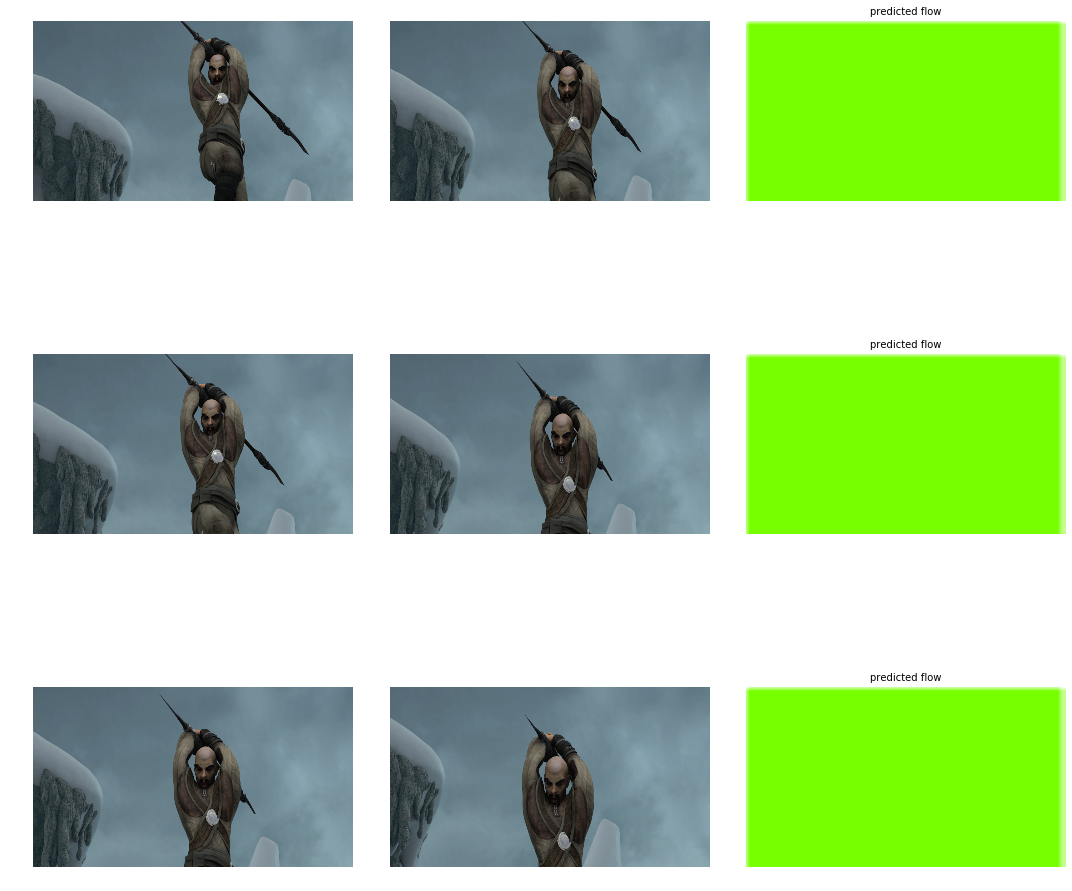

In [40]:
display_img_pairs_w_flows(img_pairs, pred_labels)

In [33]:
# Instantiate the model in inference mode and display the model configuration

nn = ModelPWCNet(mode='test', options=nn_opts)
nn.print_config()

Building model...
... model built.
Loading model checkpoint ./models/pwcnet-sm-6-2-cyclic-chairsthingsmix-fp16_lvl3/pwcnet.ckpt-98000 for eval or testing...

INFO:tensorflow:Restoring parameters from ./models/pwcnet-sm-6-2-cyclic-chairsthingsmix-fp16_lvl3/pwcnet.ckpt-98000


NotFoundError: Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Key pwcnet/ctxt/dc_conv31/bias not found in checkpoint
	 [[node save/RestoreV2 (defined at /Vol0/user/f.konokhov/tfoptflow/tfoptflow/model_base.py:119)  = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2/tensor_names, save/RestoreV2/shape_and_slices)]]

Caused by op 'save/RestoreV2', defined at:
  File "/Vol0/user/f.konokhov/miniconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Vol0/user/f.konokhov/miniconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Vol0/user/f.konokhov/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Vol0/user/f.konokhov/miniconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Vol0/user/f.konokhov/miniconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/Vol0/user/f.konokhov/miniconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/Vol0/user/f.konokhov/miniconda3/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/Vol0/user/f.konokhov/miniconda3/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/Vol0/user/f.konokhov/miniconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/Vol0/user/f.konokhov/miniconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/Vol0/user/f.konokhov/miniconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Vol0/user/f.konokhov/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/Vol0/user/f.konokhov/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/Vol0/user/f.konokhov/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/Vol0/user/f.konokhov/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/Vol0/user/f.konokhov/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/Vol0/user/f.konokhov/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/Vol0/user/f.konokhov/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/Vol0/user/f.konokhov/miniconda3/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/Vol0/user/f.konokhov/miniconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Vol0/user/f.konokhov/miniconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Vol0/user/f.konokhov/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Vol0/user/f.konokhov/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/Vol0/user/f.konokhov/miniconda3/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/Vol0/user/f.konokhov/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Vol0/user/f.konokhov/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/Vol0/user/f.konokhov/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-33-b1b5bc60a5f9>", line 3, in <module>
    nn = ModelPWCNet(mode='test', options=nn_opts)
  File "/Vol0/user/f.konokhov/tfoptflow/tfoptflow/model_pwcnet.py", line 231, in __init__
    super().__init__(name, mode, session, options)
  File "/Vol0/user/f.konokhov/tfoptflow/tfoptflow/model_base.py", line 66, in __init__
    self.build_graph()
  File "/Vol0/user/f.konokhov/tfoptflow/tfoptflow/model_base.py", line 266, in build_graph
    self.init_saver()
  File "/Vol0/user/f.konokhov/tfoptflow/tfoptflow/model_base.py", line 119, in init_saver
    self.saver = tf.train.Saver()
  File "/Vol0/user/f.konokhov/miniconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1102, in __init__
    self.build()
  File "/Vol0/user/f.konokhov/miniconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1114, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/Vol0/user/f.konokhov/miniconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1151, in _build
    build_save=build_save, build_restore=build_restore)
  File "/Vol0/user/f.konokhov/miniconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 795, in _build_internal
    restore_sequentially, reshape)
  File "/Vol0/user/f.konokhov/miniconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 406, in _AddRestoreOps
    restore_sequentially)
  File "/Vol0/user/f.konokhov/miniconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 862, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/Vol0/user/f.konokhov/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1466, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/Vol0/user/f.konokhov/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Vol0/user/f.konokhov/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/Vol0/user/f.konokhov/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/Vol0/user/f.konokhov/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

NotFoundError (see above for traceback): Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Key pwcnet/ctxt/dc_conv31/bias not found in checkpoint
	 [[node save/RestoreV2 (defined at /Vol0/user/f.konokhov/tfoptflow/tfoptflow/model_base.py:119)  = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2/tensor_names, save/RestoreV2/shape_and_slices)]]


In [ ]:
pred_labels = nn.predict_from_img_pairs(img_pairs, batch_size=3, verbose=False)

In [39]:
pred_labels = nn.predict_from_img_pairs(img_pairs, batch_size=3, verbose=False)

In batch mode, make sure to wrap around if there arent enough input samples to process 0.005245208740234375 ms
Make input samples conform to the networks requirements 446.8493461608887 ms
Run the adapted samples through the network 3859.31658744812 ms
In batch mode, make sure to wrap around if there arent enough input samples to process 0.00476837158203125 ms
Make input samples conform to the networks requirements 401.75461769104004 ms
Run the adapted samples through the network 690.8457279205322 ms
In batch mode, make sure to wrap around if there arent enough input samples to process 0.0073909759521484375 ms
Make input samples conform to the networks requirements 496.58799171447754 ms
Run the adapted samples through the network 397.174596786499 ms


In [19]:
pred_labels = nn.predict_from_img_pairs(img_pairs, batch_size=1, verbose=False)

In batch mode, make sure to wrap around if there arent enough input samples to process 0.00286102294921875 ms
Make input samples conform to the networks requirements 2.7761459350585938 ms
Run the adapted samples through the network 124.4649887084961 ms
In batch mode, make sure to wrap around if there arent enough input samples to process 0.0045299530029296875 ms
Make input samples conform to the networks requirements 1.9822120666503906 ms
Run the adapted samples through the network 123.47674369812012 ms
In batch mode, make sure to wrap around if there arent enough input samples to process 0.0050067901611328125 ms
Make input samples conform to the networks requirements 1.6214847564697266 ms
Run the adapted samples through the network 120.58806419372559 ms


# SMALL

## CPU

### 640 360

In [ ]:
# start = time.time()
# for i in range(50):
#     pred_labels = nn.predict_from_img_pairs(img_pairs, batch_size=1, verbose=False)
# end = time.time()
# print('Total time',(end-start)/50)

### 320 180

In [ ]:
# start = time.time()
# for i in range(50):
#     pred_labels = nn.predict_from_img_pairs(img_pairs, batch_size=1, verbose=False)
# end = time.time()
# print('Total time',(end-start)/50)

## GPU 

### 640 360

In [ ]:
# start = time.time()
# for i in range(50):
#     pred_labels = nn.predict_from_img_pairs(img_pairs, batch_size=1, verbose=False)
# end = time.time()
# print((end-start)/50)

### 320 180

In [ ]:
# start = time.time()
# for i in range(50):
#     pred_labels = nn.predict_from_img_pairs(img_pairs, batch_size=1, verbose=False)
# end = time.time()
# print((end-start)/50)

# Large 

## CPU

### 640 360 

In [ ]:
# start = time.time()
# for i in range(50):
#     pred_labels = nn.predict_from_img_pairs(img_pairs, batch_size=1, verbose=False)
# end = time.time()
# print((end-start)/50)

### 320 180 

In [ ]:
# start = time.time()
# for i in range(50):
#     pred_labels = nn.predict_from_img_pairs(img_pairs, batch_size=1, verbose=False)
# end = time.time()
# print((end-start)/50)

## GPU

### 640 360 

In [ ]:
# start = time.time()
# for i in range(50):
#     pred_labels = nn.predict_from_img_pairs(img_pairs, batch_size=1, verbose=False)
# end = time.time()
# print((end-start)/50)

### 320 180 

In [ ]:
# start = time.time()
# for i in range(50):
#     pred_labels = nn.predict_from_img_pairs(img_pairs, batch_size=1, verbose=False)
# end = time.time()
# print((end-start)/50)

In [ ]:
Large PWC: gpu big 0.04, small 0.028, cpu big 0.48, small 0.12
Small PWC: gpu big 0.03, small 0.020, cpu big 0.22, small 0.05 
seconds